# MicroGrad
A tiny Autograd engine. Implements backpropogation (reverse-mode autodiff) over a dynamically build DAG and a small neural network library on top of it with a PyTorch-like API. Both are tiny, with about 100 and 50 lines of code respectively. The DAG only operates over scalar values, so e.g. we chop up each neuron into all of it's individual tiny adds and multiplies. However, this is enough to build up entire deep neural nets doing binary classification, as the demo notebook shows.

In [232]:
import math 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import math

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3)

20

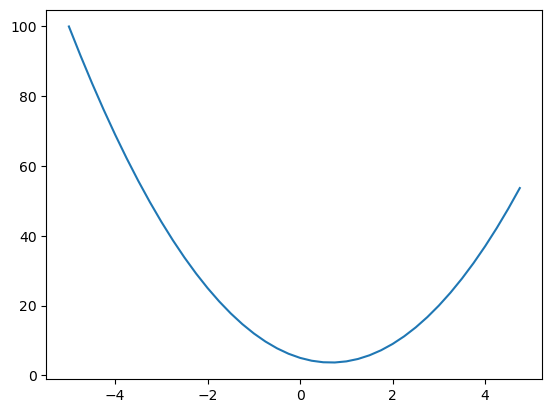

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [15]:
h = 0.00000000001
x = -3.0
print(f(x), f(x + h))
print((f(x+h) - f(x)) / h)

44.0 43.99999999978
-21.999824184604222


In [7]:
# let's go more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [17]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# let's increase a's value little bit and check the slope 
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2) 
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [26]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# let's increase b's value little bit and check the slope 
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2) 
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [28]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# let's increase c's value little bit and check the slope 
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2) 
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [375]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data 
        self.grad = 0.0
        self._backward = lambda: None  
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad 
            
        out._backward = _backward
        return out 

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad 
        out._backward = _backward
        return out 

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c 
d.label='d'
f = Value(-2.0, label='f')
L = d * f
L.label= 'L'
L

# (a.__mul__(b)).__add__(c)

Value(data=-8.0)

In [312]:
d._prev, d._op

({Value(data=-6.0), Value(data=10.0)}, '+')

In [80]:
import os
os.environ["PATH"] += r";;C:\Users\yashs\Downloads\windows_10_cmake_Release_Graphviz-12.2.1-win64\Graphviz-12.2.1-win64\bin"  # Change this to where Graphviz is installed


In [120]:
from graphviz import Digraph

class Node:
    def __init__(self, data, op=None):
        self.data = data
        self._op = op
        self._prev = []

# Example function to add edges
def add_edge(node1, node2):
    node2._prev.append(node1)

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [122]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c 
d.label='d'
f = Value(-2.0, label='f')
L = d * f
L.label= 'L'
L

Value(data=-8.0)

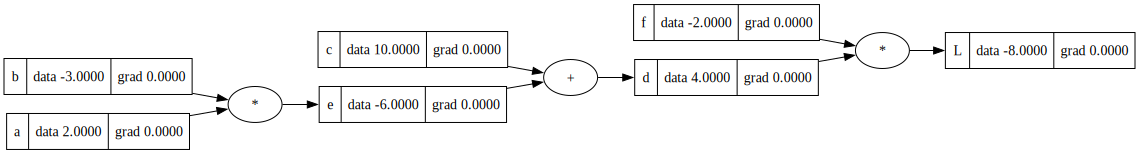

In [124]:
draw_dot(L)

In [136]:
def lol():
    h = 0.0000001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c 
    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f
    L.label= 'L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c 
    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f
    L.label= 'L'
    L2 = L.data  + h
    print((L2 - L1)/h)
    
lol()

1.0000000028043132


In [139]:
L.grad = 1

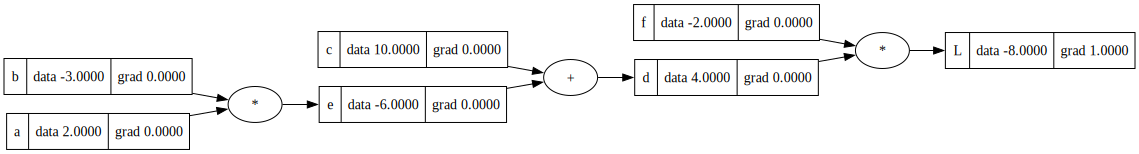

In [141]:
draw_dot(L)

Derivative Calculation: Multiplication Operation

**1. Local Derivatives:**

Given: $L = d \cdot f$

* $\frac{dL}{dd} = \lim_{h \to 0} \frac{(d+h)f - df}{h} = \lim_{h \to 0} \frac{df + hf - df}{h} = \lim_{h \to 0} \frac{hf}{h} = f$
* $\frac{dL}{df} = \lim_{h \to 0} \frac{d(f+h) - df}{h} = \lim_{h \to 0} \frac{df + dh - df}{h} = \lim_{h \to 0} \frac{dh}{h} = d$

**Interpretation:**

In a multiplication operation ($L = d \cdot f$), the local derivative of the output with respect to one input is the other input. Specifically:

* $\frac{dL}{dd} = f$
* $\frac{dL}{df} = d$

This means that the gradient flowing back through the multiplication operation will be scaled by the value of the other input.

In [143]:
f.grad = 4.0
d.grad = -2.0

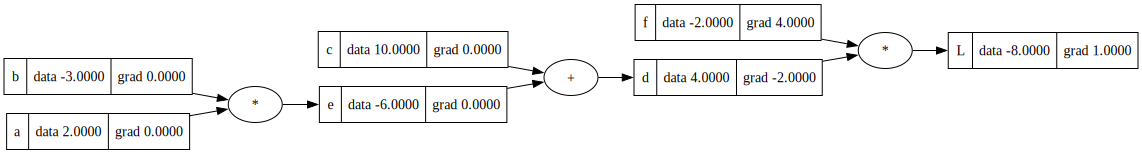

In [145]:
draw_dot(L)

In [150]:
# let's pump f a little and see what happend with L ?
def lol():
    h = 0.0000001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c 
    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f
    L.label= 'L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c 
    d.label='d'
    f = Value(-2.0 + h, label='f')
    L = d * f
    L.label= 'L'
    L2 = L.data
    print((L2 - L1)/h)
    
lol()

4.000000002335469


In [158]:
# Let's pump d a little and see what happened with L 
def lol():
    h = 0.0000001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c 
    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f
    L.label= 'L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c 
    d.label='d'
    f = Value(-2.0, label='f')
    # increase d 
    d.data += h
    L = d * f
    L.label= 'L'
    L2 = L.data
    print((L2 - L1)/h)
    
lol()

-2.0000000056086265


Derivative Calculation: Gradient Flow

**1. Local Derivatives:**

Given: $d = c + e$

* $\frac{dd}{dc} = \lim_{h \to 0} \frac{(c+h+e) - (c+e)}{h} = \lim_{h \to 0} \frac{h}{h} = 1$
* $\frac{dd}{de} = \lim_{h \to 0} \frac{(c+e+h) - (c+e)}{h} = \lim_{h \to 0} \frac{h}{h} = 1$

**2. Chain Rule Application:**

Given: $\frac{dL}{dd} = -2$

* $\frac{dL}{dc} = \frac{dL}{dd} \cdot \frac{dd}{dc} = -2 \cdot 1 = -2$
* $\frac{dL}{de} = \frac{dL}{dd} \cdot \frac{dd}{de} = -2 \cdot 1 = -2$

**Interpretation:**

The addition operation ($d = c + e$) results in local derivatives of 1. This means the incoming gradient ($\frac{dL}{dd}$) is passed through unchanged to the preceding variables ($c$ and $e$) via the chain rule. In essence, addition acts as a gradient router.

In [161]:
c.grad = -2.0
e.grad = -2.0


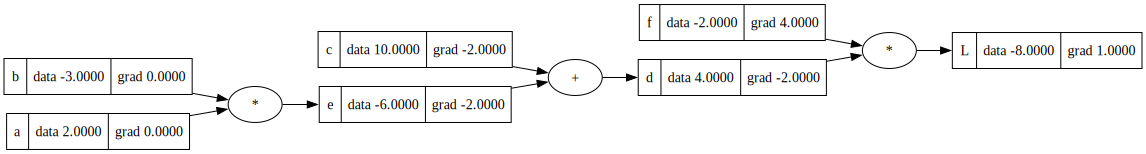

In [163]:
draw_dot(L)

In [175]:
# let's verify 
# Let's pump c a little and see what happened with L 
def lol():
    h = 0.0000001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c 
    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f
    L.label= 'L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    c.data += h
    d = e + c 
    d.label='d'
    f = Value(-2.0, label='f')
    
    L = d * f
    L.label= 'L'
    L2 = L.data
    print((L2 - L1)/h)
    
lol() # approx -2.0

# Let's pump 'e' a little and see what happened with L 
def lol():
    h = 0.0000001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c 
    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f
    L.label= 'L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    e.data += h
    d = e + c 
    d.label='d'
    f = Value(-2.0, label='f')

    L = d * f
    L.label= 'L'
    L2 = L.data
    print((L2 - L1)/h)
    
lol() # approx -2.0

-1.999999987845058
-2.0000000056086265


**Derivative Calculation: Multiplication with Chain Rule**

**1. Local Derivatives:**

Given: $e = a \cdot b$

* $\frac{de}{da} = \lim_{h \to 0} \frac{(a+h)b - ab}{h} = b$
* $\frac{de}{db} = \lim_{h \to 0} \frac{a(b+h) - ab}{h} = a$

**2. Chain Rule Application:**

Given: $\frac{dL}{de} = -2.0$

* $\frac{dL}{da} = \frac{dL}{de} \cdot \frac{de}{da} = -2.0 \cdot b$

 We know that $b = 3.0$:

* $\frac{dL}{da} = -2.0 \cdot 3.0 = -6.0$

* $\frac{dL}{db} = \frac{dL}{de} \cdot \frac{de}{db} = -2.0 \cdot a$

We know that $a = 2.0$:

* $\frac{dL}{db} = -2.0 \cdot 2.0 = -4.0$

**Step-by-Step Derivation:**

For $\frac{de}{da}$:

1.  $e = a \cdot b$
2.  $\frac{de}{da} = \lim_{h \to 0} \frac{f(a+h) - f(a)}{h}$
3.  $\frac{de}{da} = \lim_{h \to 0} \frac{(a+h)b - ab}{h}$
4.  $\frac{de}{da} = \lim_{h \to 0} \frac{ab + hb - ab}{h}$
5.  $\frac{de}{da} = \lim_{h \to 0} \frac{hb}{h}$
6.  $\frac{de}{da} = b$

For $\frac{dL}{da}$:

1.  $\frac{dL}{da} = \frac{dL}{de} \cdot \frac{de}{da}$
2.  $\frac{dL}{da} = -2.0 \cdot b$
3.  If $b = 3.0$, then $\frac{dL}{da} = -2.0 \cdot 3.0 = -6.0$

Similarly for $\frac{de}{db}$ and $\frac{dL}{db}$.

**Interpretation:**

In a multiplication operation, the derivative of the output with respect to each input is the other input. When using the chain rule, the gradient flowing back is scaled by the value of the other input.

In [179]:
a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)

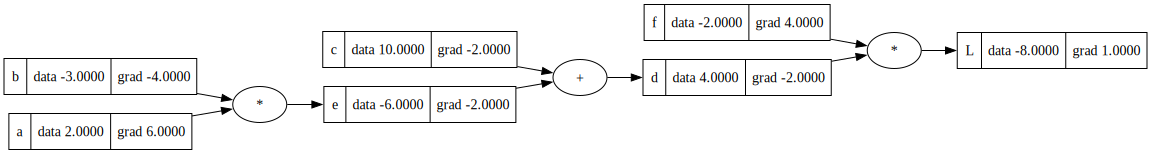

In [181]:
draw_dot(L)

In [195]:
# let's verify
# Let's pump 'a' a little and see what happened with L 
def lol():
    h = 0.0000001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c 
    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f
    L.label= 'L'
    L1 = L.data

    a = Value(2.0 + h , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c 
    d.label='d'
    f = Value(-2.0, label='f')

    L = d * f
    L.label= 'L'
    L2 = L.data
    print((L2 - L1)/h)
    
lol() # approx 6.0

# Let's pump 'b' a little and see what happened with L 
def lol():
    h = 0.0000001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c 
    d.label='d'
    f = Value(-2.0, label='f')
    L = d * f
    L.label= 'L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c 
    d.label='d'
    f = Value(-2.0, label='f')

    L = d * f
    L.label= 'L'
    L2 = L.data
    print((L2 - L1)/h)
    
lol() # approx -4.0

5.999999999062311
-3.9999999934536845


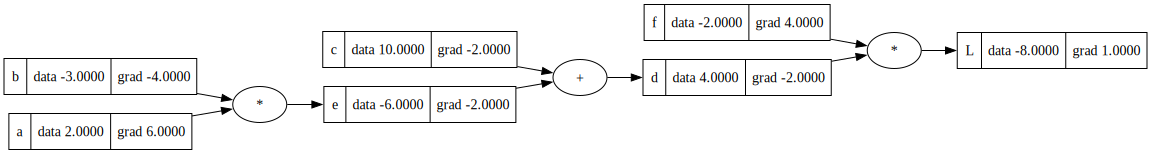

In [197]:
draw_dot(L)

In [199]:
# let's try to increase the value of L

In [203]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f
print(L.data)


-6.586368000000001


**Gradient Descent: Adjusting Values to Increase Loss (L)**

Let's understand why we're making these adjustments to `a`, `b`, `c`, and `f` using their gradients, and how it affects the loss `L`.

**What are Gradients?**

Imagine you're on a hill, and you want to find the highest point. Gradients are like arrows pointing in the direction of the steepest climb. In our code, `a.grad`, `b.grad`, `c.grad`, and `f.grad` tell us how much each variable affects the loss `L`.


**What's Happening?**

* We are taking the gradient of each variable (e.g., `a.grad`) and multiplying it by `0.01`.
* This `0.01` is the **learning rate**, a small value that controls the step size of our adjustments.
* We then *add* this small change to the variable's current value (e.g., `a.data`).

**Why Add Instead of Subtract?**

* Typically, in machine learning, we *subtract* gradients to *decrease* the loss `L`. This is like moving *downhill* to find a minimum.
* In this example, we are *adding* gradients, which means we are intentionally *increasing* the loss `L`.

**Why Would We Want to Increase Loss?**

* Increasing loss is not a standard practice in model training.
* We do it here for educational purposes, to understand how gradients affect loss.

**How Adding Gradients Increases Loss:**

* If `a.grad` is positive, `0.01 * a.grad` is positive, so `a.data` increases.
* If `a.grad` is negative, `0.01 * a.grad` is negative, so `a.data` decreases.
* The same logic applies to `b`, `c`, and `f`.
* Due to the chain rule, positive gradients generally lead to higher loss when added, and negative gradients to lower loss when added.

**The Result:**

```python
e = a * b
d = e + c
L = d * f
print(L.data)

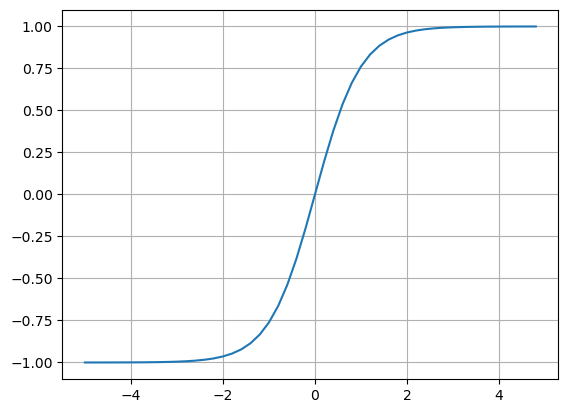

In [220]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()
plt.show()

In [246]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

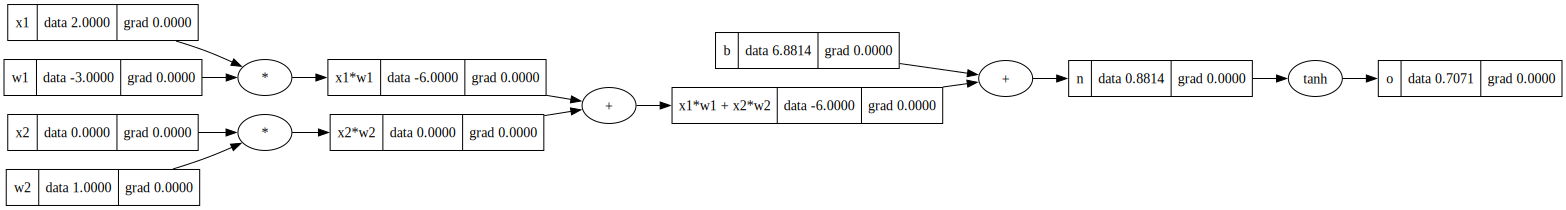

In [248]:
draw_dot(o)

In [252]:
# do/do = 1
o.grad = 1.0

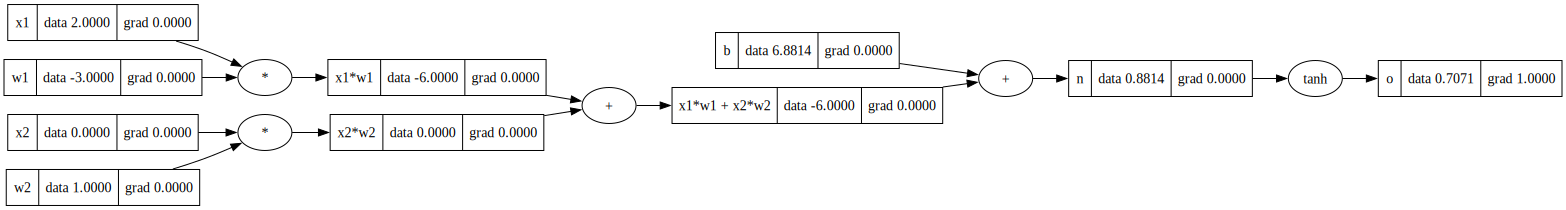

In [254]:
draw_dot(o)

In [258]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
# do/dn = 1 - o**2
1 - o.data**2

0.4999999999999999

In [260]:
n.grad = 0.5

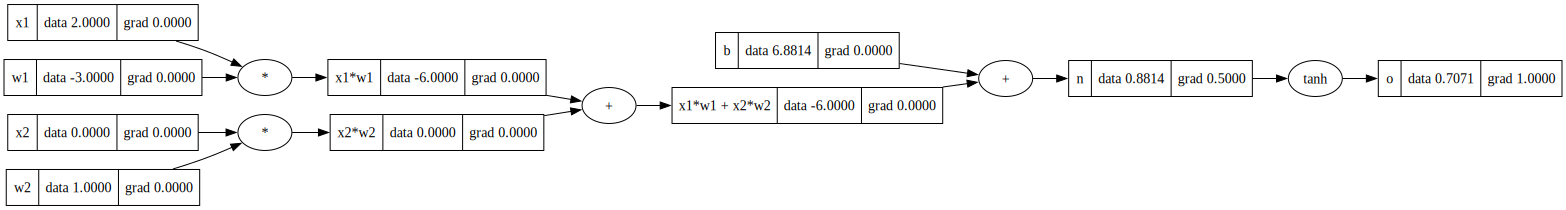

In [262]:
draw_dot(o)

In [264]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

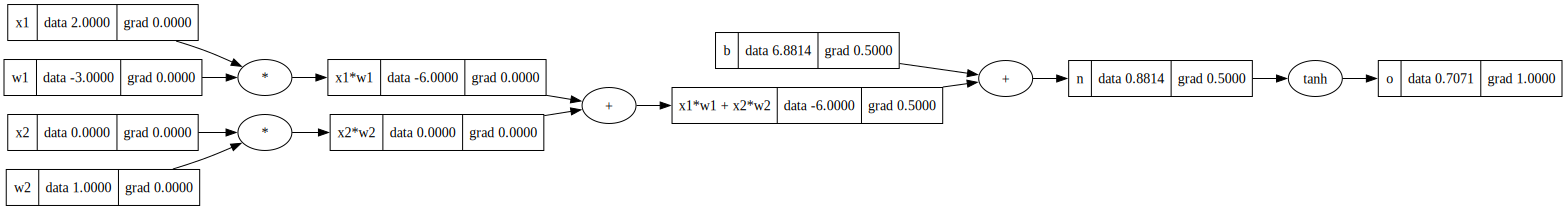

In [266]:
draw_dot(o)

In [268]:
x1w1.grad = 0.5
x2w2.grad = 0.5

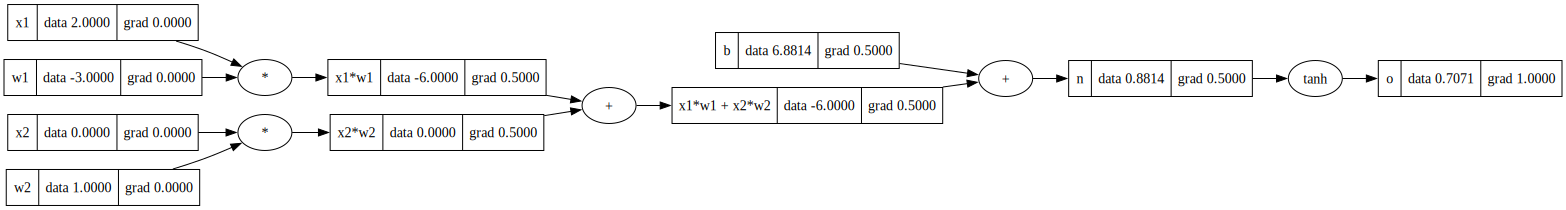

In [270]:
draw_dot(o)

In [272]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

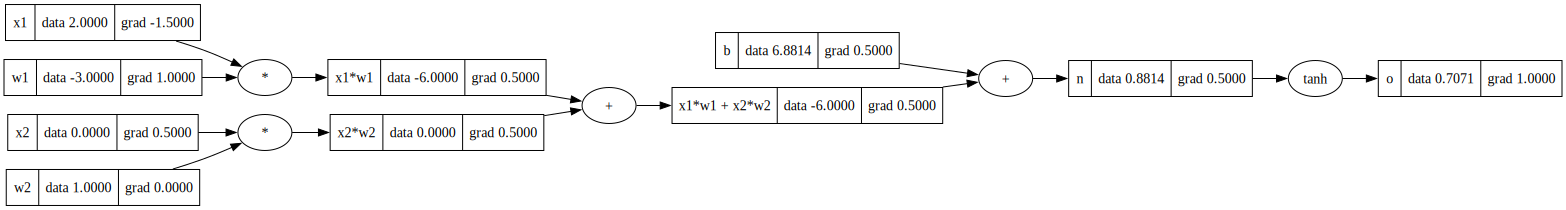

In [274]:
draw_dot(o)

In [320]:
# Compute gradients automatically.
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

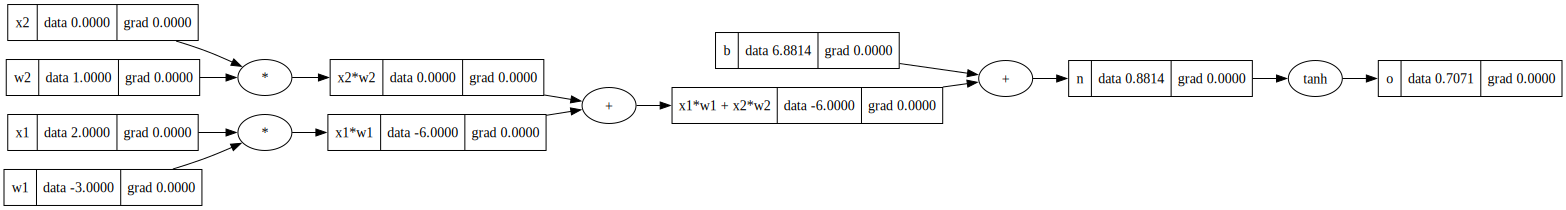

In [322]:
draw_dot(o)

In [324]:
o.grad = 1.0
o._backward()

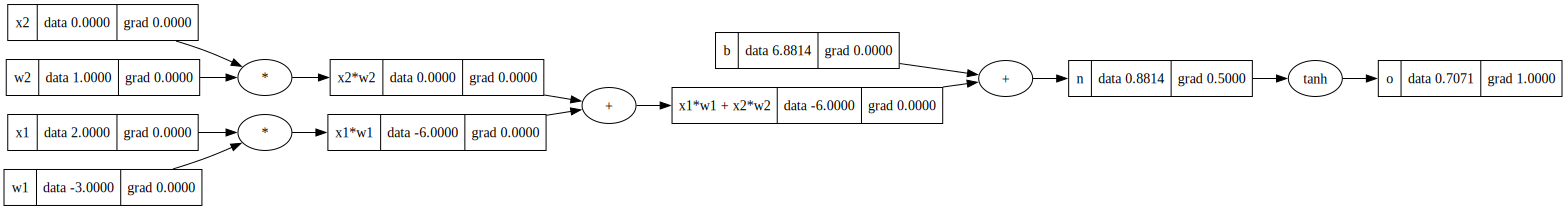

In [326]:
draw_dot(o)

In [328]:
n._backward()

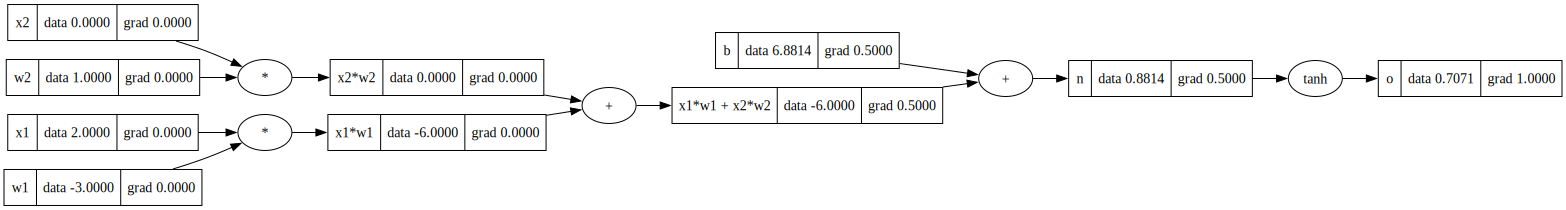

In [330]:
draw_dot(o)

In [332]:
b._backward()

In [334]:
x1w1x2w2._backward()

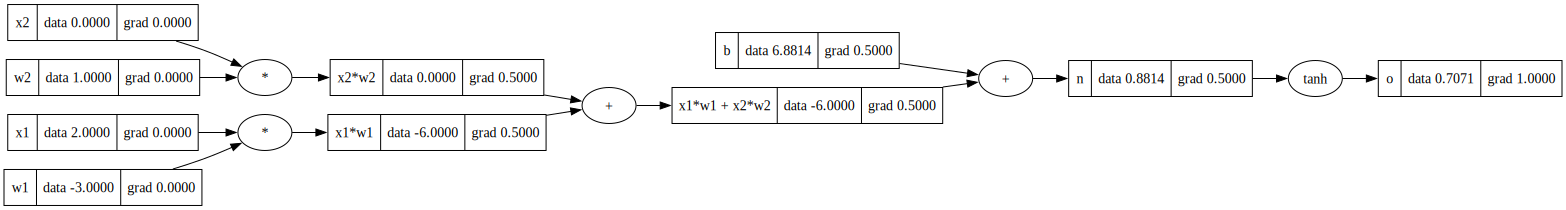

In [336]:
draw_dot(o)

In [338]:
x2w2._backward()
x1w1._backward()

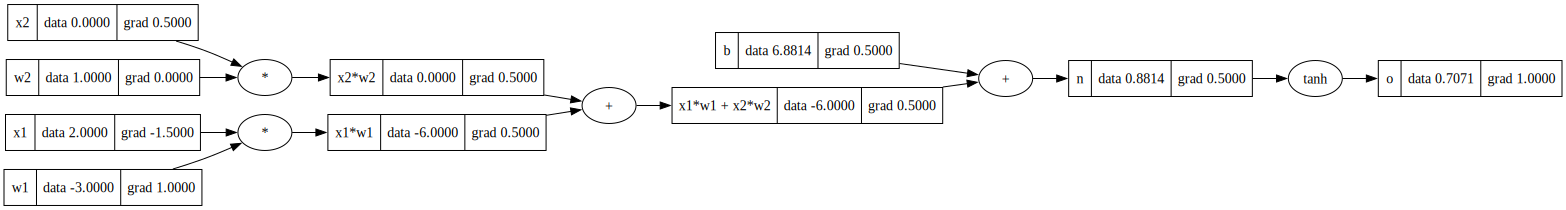

In [340]:
draw_dot(o)

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [360]:
# Compute gradients automatically.
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

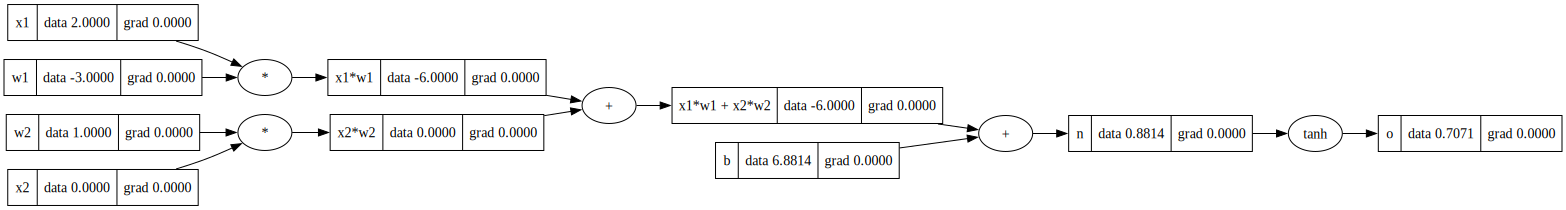

In [362]:
# reset's gradients to zero
draw_dot(o)

In [354]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

In [364]:
o.backward()

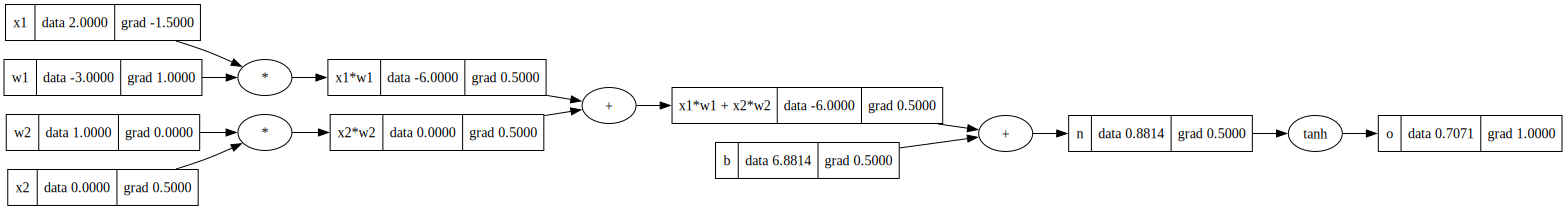

In [366]:
draw_dot(o)

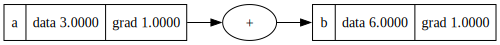

In [368]:
# bug in our code 
a = Value(3.0, label='a')
b = a + a ; b.label='b'
b.backward()
draw_dot(b)

the gradient should be 2 not 1 because db/da = 2

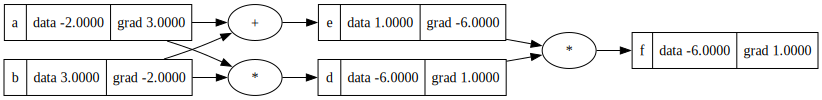

In [373]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label='d'
e = a + b ; e.label='e'
f = d * e ; f.label='f'
f.backward()
draw_dot(f)

the "*" will overwrite the gradients computed by "+" the best thing we can do this accumulate the gradients by summing.


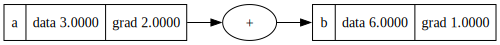

In [380]:
# let's see += works or not 
a = Value(3.0, label='a')
b = a + a ; b.label='b'
b.backward()
draw_dot(b)

In [382]:
# yes now the gradient is 2 instead of 1.

In [428]:
# Additional functionality

In [420]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data 
        self.grad = 0.0
        self._backward = lambda: None  
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad 
            
        out._backward = _backward
        return out 

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad 
        out._backward = _backward
        return out 

    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int/float powers for now'
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
        out._backward = _backward
        return out 

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other):
        return self + (-other)
        
    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out 

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [426]:
a = Value(2.0)
a + 1
a * 1
2 * a # error
a.exp()
b = Value(4.0)
a / b
a-b
-a

Value(data=-2.0)

In [430]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()


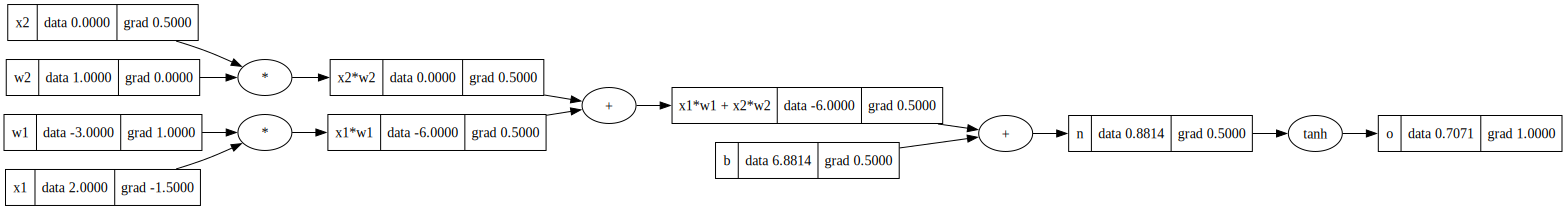

In [432]:
draw_dot(o)

In [434]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
# ----
e = (2*n).exp() # tanhx = e**2x - 1 / (e**2x + 1)
o = (e - 1) / (e + 1); o.label='o'

o.backward()


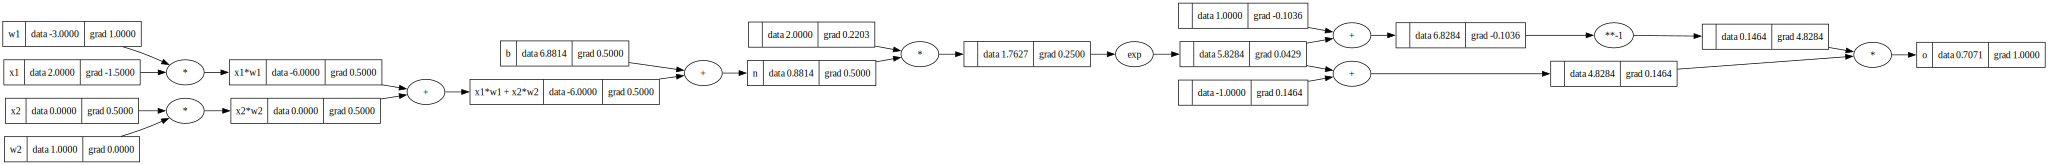

In [436]:
draw_dot(o)

### Using pytorch

In [447]:
import torch 

In [451]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [474]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [460]:
torch.Tensor([[1,2,3], [4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [464]:
torch.Tensor([2.0]).double()

tensor([2.], dtype=torch.float64)

In [476]:
import random

In [569]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh() 
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [571]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

n(x)

Value(data=0.4218143661198511)

In [589]:
len(n.parameters())

41

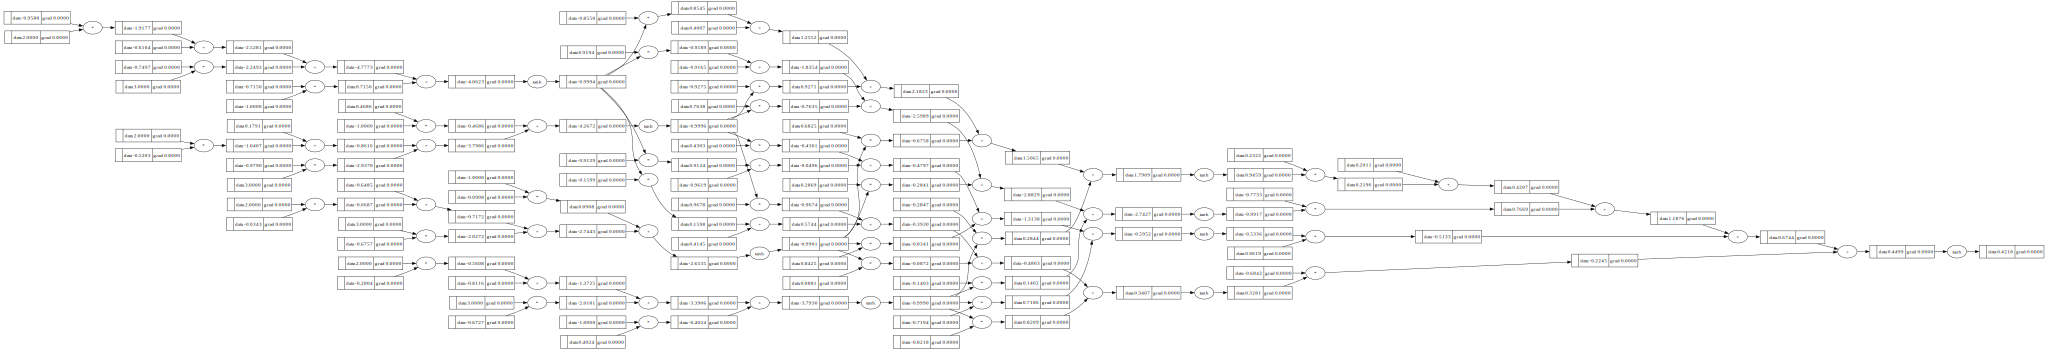

In [573]:
draw_dot(n(x))

In [576]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.4218143661198511),
 Value(data=0.7055398548478656),
 Value(data=0.35404001224091874),
 Value(data=0.43289133102980437)]

In [578]:
# compute the loss 
loss = Value(0)  # Initialize with a Value object
for ygt, yout in zip(ys, ypred):
    loss += (yout - ygt) ** 2
loss

Value(data=5.398201420870403)

In [670]:
loss.backward()

In [582]:
n.layers[0].neurons[0].w[0].grad

0.027135678867404478

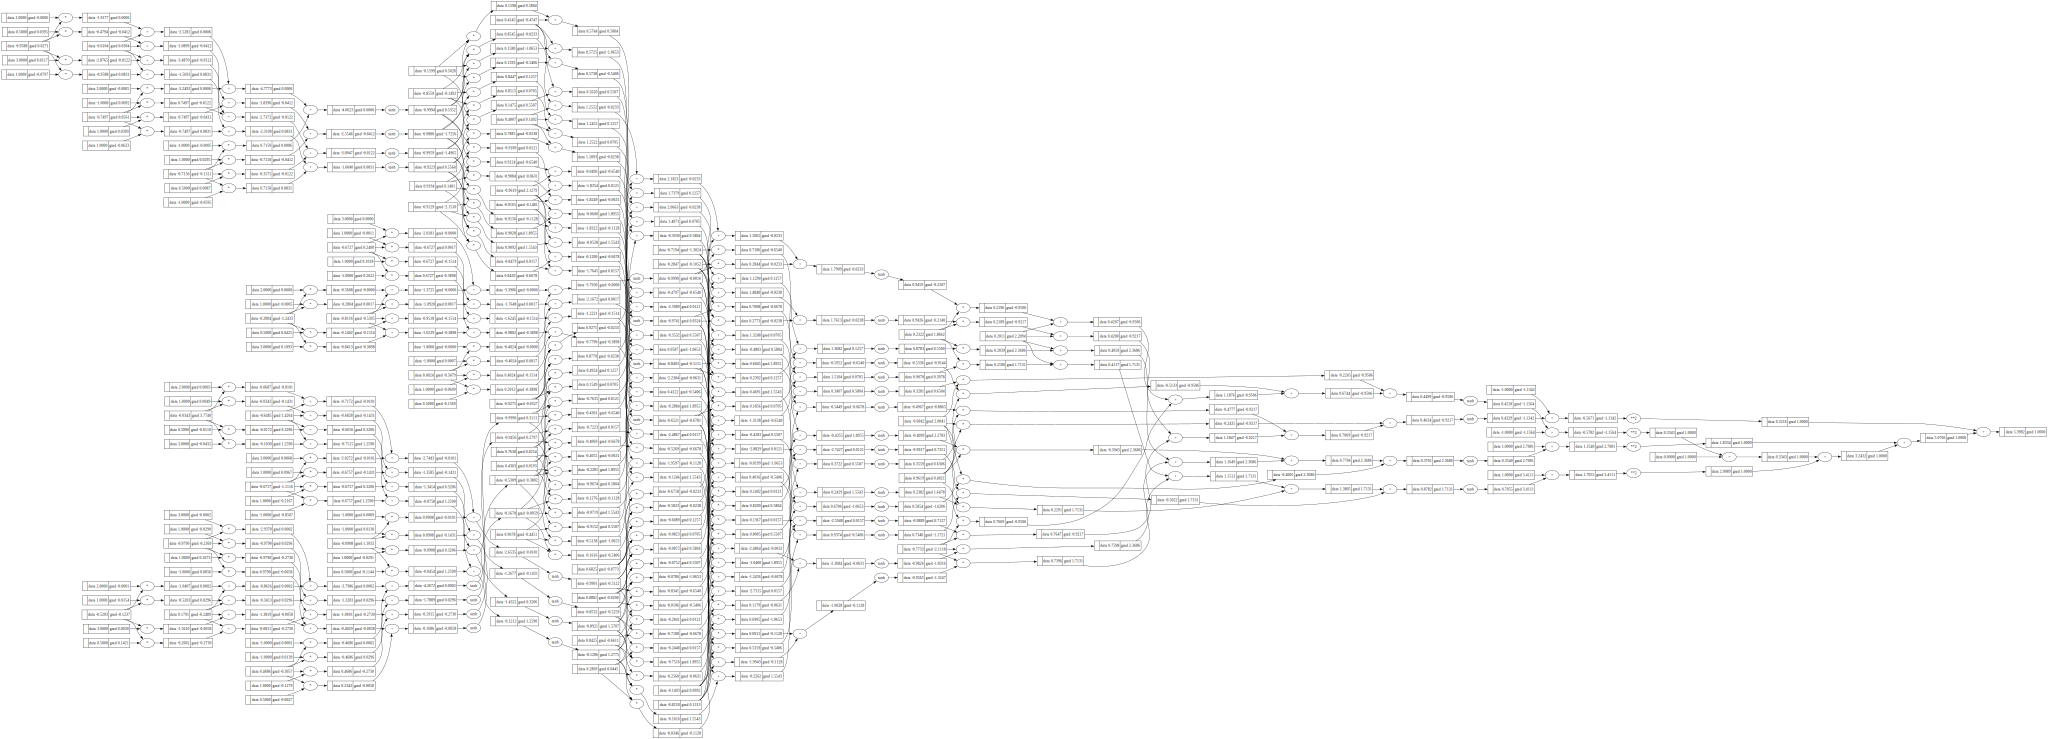

In [584]:
draw_dot(loss)

In [702]:
loss.backward()
for p in n.parameters():
    p.data += -0.01 * p.grad


In [704]:
# let's see if the loss decreases or not

In [706]:
ypred = [n(x) for x in xs]
loss = Value(0)  # Initialize with a Value object
for ygt, yout in zip(ys, ypred):
    loss += (yout - ygt) ** 2
loss

Value(data=5.785626383387647e-07)

Yes it does.

In [709]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9998118033730463),
 Value(data=-0.9995968674322943),
 Value(data=-0.9994179501485687),
 Value(data=0.9997954351661555)]

In [711]:
n.parameters()

[Value(data=-1.0479028410795523),
 Value(data=-0.878464561525223),
 Value(data=-0.4748604685326398),
 Value(data=-0.7022800463161578),
 Value(data=1.6405736083315954),
 Value(data=-0.9629900357230992),
 Value(data=3.846304095524049),
 Value(data=1.922441307190197),
 Value(data=-4.3185619397986565),
 Value(data=0.7552386336171291),
 Value(data=-1.4009901294652163),
 Value(data=-2.1773436480685016),
 Value(data=0.7002276838736246),
 Value(data=-0.6314759480054349),
 Value(data=0.861781805095359),
 Value(data=-0.21863867541091445),
 Value(data=-0.5725738788122546),
 Value(data=-0.9433559100563923),
 Value(data=0.8777411954072318),
 Value(data=-0.18762849242079996),
 Value(data=0.12109222476470022),
 Value(data=0.7129649166662166),
 Value(data=0.7909490639343947),
 Value(data=0.17554753596255068),
 Value(data=-0.21869961503886529),
 Value(data=-0.7122191465318266),
 Value(data=0.7917372218652637),
 Value(data=-1.1888753780410237),
 Value(data=1.084987998096647),
 Value(data=-0.523083577897

In [728]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [730]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = Value(0)  # Initialize with a Value object
    for ygt, yout in zip(ys, ypred):
        loss += (yout - ygt) ** 2
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    # update 
    for p in n.parameters():
        p.data += -0.01 * p.grad
    print(k, loss.data)    
    

0 2.656070077982769e-10
1 2.656070076089713e-10
2 2.656070074196327e-10
3 2.6560700723285973e-10
4 2.6560700704607283e-10
5 2.6560700685673424e-10
6 2.656070066673957e-10
7 2.6560700647805706e-10
8 2.6560700629127016e-10
9 2.656070061019316e-10
10 2.6560700591259303e-10
11 2.6560700572325444e-10
12 2.6560700553646754e-10
13 2.6560700534969456e-10
14 2.6560700516035596e-10
15 2.6560700497101737e-10
16 2.656070047842305e-10
17 2.656070045948919e-10
18 2.6560700440555335e-10
19 2.656070042162147e-10


In [732]:
ypred 

[Value(data=0.9999885082531306),
 Value(data=-0.9999998518321916),
 Value(data=-0.9999998514455151),
 Value(data=0.9999884456615953)]